In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from IPython.display import display

In [2]:
benchmark_results = []
for path in glob.glob('../../benchmarks/2020-12-15-independent-large-regen-1/*.csv'):
    benchmark_results.append(pd.read_csv(path))
benchmark_results = pd.concat(benchmark_results)

benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,mpi_procs,timeout_seconds,mpi_comm_world,micros_input,micros_precompute,micros_until_len,micros_edit_script,min_edit_length
2,2,independent,1426666,1,0,zipf,0,0,mpi_no_master_frontier,256,600.0,256,1553490,0,53930143,0,2514712
8,6,independent,4040000,1,0,zipf,0,0,mpi_no_master_frontier,1024,600.0,1024,1813823,0,105231156,0,7183720
7,6,independent,4040000,1,0,zipf,0,0,mpi_no_master_frontier,512,600.0,512,2716868,0,247859073,0,7183720
4,1,independent,773333,1,0,zipf,0,0,mpi_no_master_frontier,256,600.0,256,2661189,0,14229771,0,1355262
0,0,independent,120000,1,0,zipf,0,0,mpi_priority_frontier,128,600.0,128,19110,0,1273570,0,205696


In [6]:
def prepare_plot_data(filter_cb, index, map_cb = lambda temp: temp):
    temp = benchmark_results.copy()
    temp = map_cb(temp)
    temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
    temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).min()
    temp = filter_cb(temp)
    temp = temp.set_index(index, append=True)
    temp = temp.unstack('mpi_procs')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()
    return temp

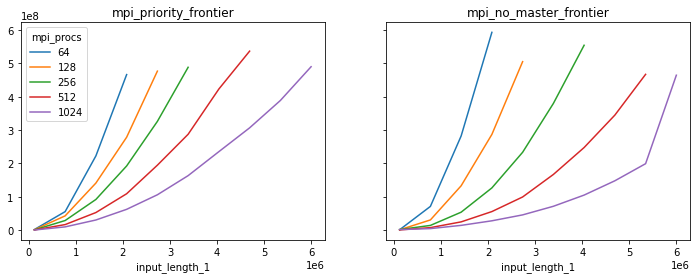

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier']):
    temp = prepare_plot_data(
        lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == 'independent')],
        'input_length_1',
    )
    temp = temp.droplevel('diff_program')
    temp.plot(ax=ax[diff_program_i], legend=(diff_program_i == 0), title=diff_program);

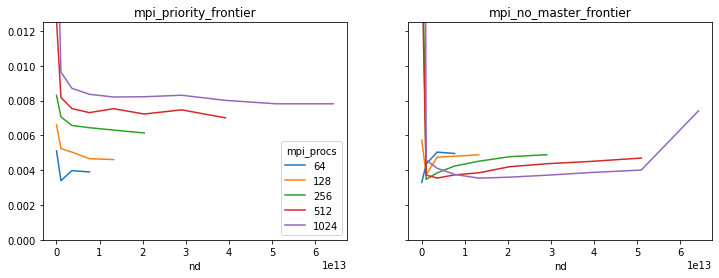

In [10]:
def map_data_for_plot(temp):
    temp['nd'] = temp['input_length_1'] * temp['min_edit_length']
    temp['micros_until_len'] = temp['micros_until_len'] * temp['mpi_procs'].fillna(1) / temp['nd']
    return temp

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier']):
    temp = prepare_plot_data(
        lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == 'independent')],
        'nd',
        map_data_for_plot,
    )
    temp = temp.droplevel('diff_program')
    temp.plot(ax=ax[diff_program_i], legend=(diff_program_i == 0), title=diff_program, ylim=(0, 0.0125));

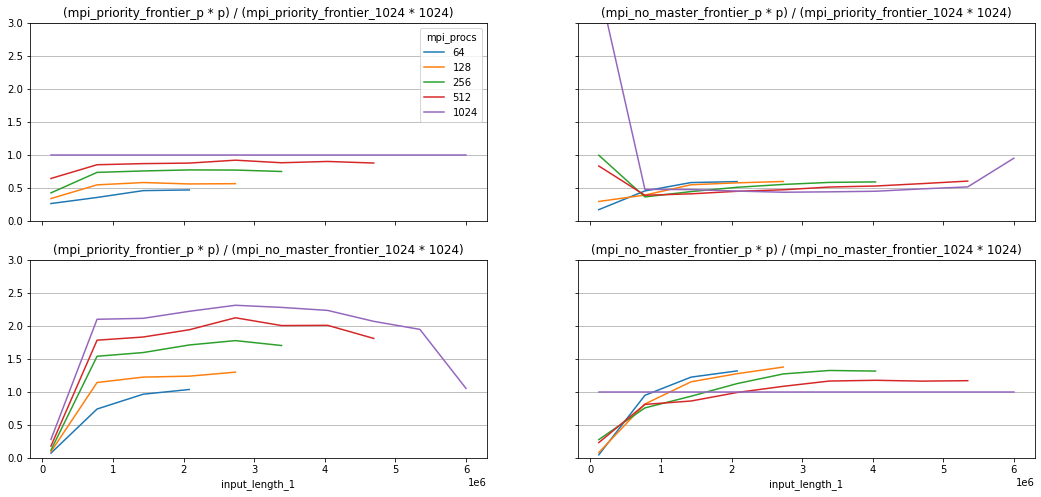

In [5]:
reference_cores = 1024

fig, ax = plt.subplots(2, 2, figsize=(18, 8), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier']):
    for reference_program_i, reference_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier']):
        temp = benchmark_results.copy()
        temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
        temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).min()
        temp = temp[temp['input_strategy'] == 'independent']
        temp_2 = temp.xs(diff_program, level='diff_program').set_index("input_length_1", append=True)["micros_until_len"].unstack("mpi_procs").droplevel(0)
        temp_3 = temp.xs(reference_program, level='diff_program').xs(reference_cores, level='mpi_procs').set_index("input_length_1")["micros_until_len"]
        temp = temp_2.divide(temp_3, axis=0)
        temp *= temp.columns.values / reference_cores
        temp.plot(ax=ax[reference_program_i][diff_program_i], legend=(reference_program_i == 0 and diff_program_i == 0), title=f'({diff_program}_p * p) / ({reference_program}_{reference_cores} * 1024)', ylim=(0, 3), grid=True);
        ax[reference_program_i][diff_program_i].grid(axis='x')